# Sentiment Analysis

From exploratory analysis I saw that the occupancy rate depends a lot on opinion and ratings that previous tourists left. Therefore I will be taking a closer look at reviews for AirBnB listings in Paris. Using existing tools I will calculate sentiment analysis for each review and will take it's average as a new charecteristic of listings.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load listings data
df = pd.read_csv("entire_home_listings.csv")
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,neighbourhood,latitude,...,instant_bookable,cancellation_policy,total_listings_per_host,reviews_per_month_total,is_host_near,amenities_count,price,reviews_per_month_2018,occupancy_rate,income
0,3109,3631,2008-10-14,within a day,1.000000,0,41,0,Observatoire,48.83349,...,f,flexible,1,0.27,t,246,75.0,0.333333,3.466667,3120.0
1,5396,7903,2009-02-14,within an hour,1.000000,0,77,1,Hôtel-de-Ville,48.85100,...,t,strict,1,1.44,f,255,115.0,3.000000,31.200000,43056.0
2,7397,2626,2008-08-30,within a few hours,1.000000,0,109,1,Hôtel-de-Ville,48.85758,...,f,moderate,1,2.47,f,295,115.0,3.083333,32.066667,44252.0
3,9952,33534,2009-08-24,unknown,0.922983,1,29,0,Popincourt,48.86227,...,f,strict,1,0.22,t,395,75.0,0.833333,8.666667,7800.0
4,10586,37107,2009-09-08,within an hour,1.000000,1,170,1,Buttes-Montmartre,48.88902,...,f,strict,3,0.36,t,105,80.0,0.083333,0.866667,832.0


In [3]:
# read review data from a zipped file to a dataframe
rev = pd.read_csv('reviews_cleaned.csv.gz', compression='gzip', header=0, 
                  parse_dates = ['date'], sep=',', quotechar='"', error_bad_lines=False, low_memory=False)
rev.drop('Unnamed: 0', axis = 1, inplace=True)
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,canceled_res
0,3109,123127969,2016-12-27,12389804,Sophie,The host canceled this reservation the day bef...,True
1,3109,123274144,2016-12-28,67553494,Tom'S,The host canceled this reservation 2 days befo...,True
2,3109,207127433,2017-10-28,51636494,Patricia,Tout s'est bien déroulé. Merci bien. PG,False
3,3109,208779822,2017-11-03,4142888,Patricia,Un petit nid fouiller douillet situé dans app...,False
4,3109,234257457,2018-02-12,3539452,Dominique,The host canceled this reservation 8 days befo...,True


In [4]:
# filter for reviews only for the listings in question
x = pd.DataFrame(df['id'])
x.columns = ['listing_id']
rev_ent = x.merge(rev, on = 'listing_id')

### VaderSentiment

For sentiment analysis I will be using Vader (Valence Aware Dictionary and sEntiment Reasoner). It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. The creators of Vader built their own lexicon based on some pre-existing well-established sentiment word-banks (LIWC, ANEW, and GI) and additionally incorporated emoticons, sentiment-related acronyms (like LOL or WTF) and commonly used slang with sentiment value. 10 pre-screened and trained independent human raters rated 9000 token features. The tokens with non-zero mean and standard deviation less than 2.5 were kept and built 7500 lexical features.

For more info please refer to: https://github.com/cjhutto/vaderSentiment

However, it is not possible to apply Vader to our reviews right away. This tool gives good results for texts in English, but does not have capacity to analyze other languages. Since the listings in subject are in Paris, it is reasonable to expect reviews in different languages. Let's first check what languages were used for each review.

In [5]:
# import a package to distinguish a language of the text
import langid

In [6]:
# create array of languages used in reviews
%time
a = ['']
for i in range(rev_ent.shape[0]):
    b = rev_ent.iloc[i, 5].strip()
    #print(b)
    x = langid.classify(b)
    #print(x)
    a.append(x[0])

Wall time: 0 ns


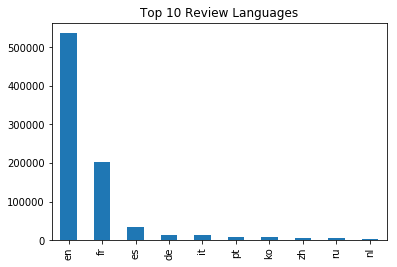

In [7]:
# show top post used languages
pd.Series(a[1:]).value_counts()[:10].plot(kind='bar')
plt.title('Top 10 Review Languages')
plt.show()

In [8]:
#numerical values
pd.Series(a[1:]).value_counts()[:10]

en    536442
fr    202757
es     34882
de     14608
it     12576
pt      9122
ko      7867
zh      7130
ru      5581
nl      3998
dtype: int64

In [9]:
rev_ent['language'] = a[1:]
rev_ent.to_csv('reviews_lang.csv')

In [10]:
rev_ent = pd.read_csv('reviews_lang.csv')
rev_ent.drop('Unnamed: 0', axis = 1, inplace=True)

### Review Translation
Most reviews are in English, but over 300,000 reviews are not and it is over 30% of data. In order to be able to analyze all of it, I will translate non-English reviews into English using googletrans package and Translator tool.

Translating reviews (especially over 300,000 of them) is time consuming. And googletrans Translator throws out an error periodically that means that it is running out of memory, so I excepting this error. 

In [11]:
# build a separate column for all comments translated into English
rev_ent.loc[:,'comments_en'] = rev_ent.loc[:,'comments'] 

In [12]:
# non-English comments are switched to empty strings
ind = rev_ent[rev_ent.language != 'en'].index
rev_ent.loc[ind,'comments_en'] = ''

In [13]:
# import libraries
import json
from googletrans import Translator
tr = Translator()

In [31]:
indx = rev_ent[rev_ent.comments_en==''].index
j = 0
error = 0
while len(indx)!=0:
    for i in indx:
        if j%10000 == 0:
            print('performed {} translations'.format(j))
        a = rev_ent.loc[i, 'comments']  
        try:
            b = tr.translate(a).text
        except json.decoder.JSONDecodeError as err: 
            error += 1                
        except ConnectionError as er:
            error +=1
        else:
            j += 1
            rev_ent.loc[i, 'comments_en'] = b
    indx = rev_ent[rev_ent.comments_en==''].index

In [29]:
# manually translate 5 left reviews (need smaller size)
x = rev_ent[rev_ent.comments_en==''].index
for i in x:
    rev_ent.loc[i,'comments_en'] = tr.translate(rev_ent.loc[i, 'comments'][:2000]).text

After translation all comments are ready for sentiment analysis.

In [32]:
# import needed tool
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [33]:
rev_ent['sentiment'] = 0

In [34]:
# perform sentiment analysis
%time
s = SentimentIntensityAnalyzer()
for i in np.arange(rev_ent.shape[0]):
    rev_ent.loc[i,'sentiment'] = s.polarity_scores(rev_ent.loc[i,'comments_en'])['compound']

Wall time: 0 ns


In [35]:
rev_ent.to_csv('reviews_sent_final.csv')

In [36]:
# calculate average sentiment for each listing id
sentiment= rev_ent.groupby('listing_id').mean().loc[:,'sentiment'].reset_index()

# add sentiment to data set of listings
df_final = df.merge(sentiment, left_on='id', right_on='listing_id')
df_final.drop('listing_id', axis=1, inplace=True)

In [37]:
#  write results to file
df_final.to_csv('entire_home_listings_sentiment.csv')

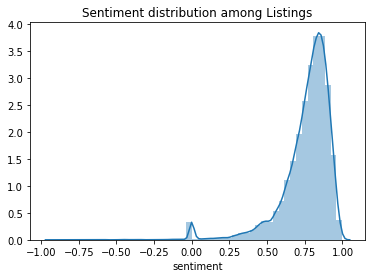

In [38]:
sns.distplot(df_final.sentiment,bins = 50)
plt.title("Sentiment distribution among Listings")
plt.show()

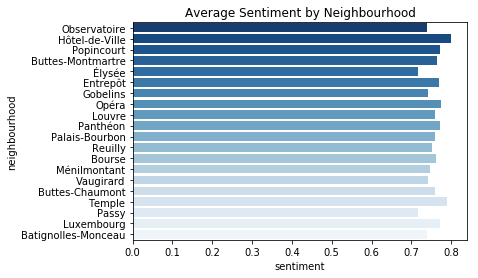

In [39]:
# plot average sentiment by neighbourhood
sns.barplot(x='sentiment', y='neighbourhood', data=df_final, palette = "Blues_r", ci=0)
plt.title('Average Sentiment by Neighbourhood')
plt.show()

The histogram and bar plot above show that most of the listings have positive sentiment analysis. It might mean that people mostly like sharing positive emotions or that most experiences were overall positive.